In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Variable():
    def __init__(self, data, T=None, grad=None, copy=True):
        if data is None or type(data) != np.ndarray:
            raise AttributeError('Wrong data type')
        
        if copy:
            self.data = data.copy()
        else:
            self.data = data
        if grad is None:
            grad = np.zeros_like(self.data)
        self.grad = grad
        if T is None:
            T = Variable(self.data.T, self, self.grad.T, copy=False)
        self.T = T
        self.fn = None
        self.child = []
        self.ready = False
    
    def zero_grad(self):
        self.grad[:,:] = 0.0
        self.child = []
        self.ready = False
    
    def __repr__(self):
        return 'Variable(\n{}\n)\n'.format(self.data.__str__())
    
    def __str__(self):
        return self.data.__str__()
    
    def __add__(self, b):
        if type(b) is not Variable:
            b = Variable(np.ones_like(self.data)*b)
            
        c = Variable(self.data + b.data)
        c.fn = [Variable.__grad_add__, self, b]
        
        self.child.append(c)
        b.child.append(c)
        return c
    
    def __grad_add__(self, a, b):
        a.grad += np.ones_like(a.grad) * self.grad
        b.grad += np.ones_like(b.grad) * self.grad
    
    def __sub__(self, b):
        if type(b) is not Variable:
            b = Variable(np.ones_like(self.data)*b)
        c = Variable(self.data - b.data)
        c.fn = [Variable.__grad_sub__, self, b]
        
        self.child.append(c)
        b.child.append(c)
        return c
    
    def __grad_sub__(self, a, b):
        a.grad += np.ones_like(a.grad) * self.grad
        b.grad -= np.ones_like(b.grad) * self.grad
    
    def __mul__(self, b):
        if type(b) is not Variable:
            b = Variable(np.ones_like(self.data)*b)
        
        c = Variable(self.data * b.data)
        c.fn = [Variable.__grad_mul__, self, b]
        
        self.child.append(c)
        b.child.append(c)
        return c
    
    def __grad_mul__(self, a, b):
        a.grad += b.data * self.grad
        b.grad += a.data * self.grad
    
    def __matmul__(self, b):
        c = Variable(np.matmul(self.data, b.data))
        c.fn = [Variable.__grad_matmul__, self, b]
           
        self.child.append(c)
        b.child.append(c)
        return c
    
    def __grad_matmul__(self, a, b):
        a.grad += np.matmul(self.grad, b.data.T)
        b.grad += np.matmul(a.data.T, self.grad)
    
    
    def tanh(self):
        c = Variable(np.tanh(self.data))
        c.fn = [Variable.__grad_tanh__, self]
        
        self.child.append(c)
        return c
        
    def __grad_tanh__(self, a):
        a.grad += self.grad * (1 - (self.data**2))
    
    def crossentropy(self, target):
        s = self.softmax(1)
        if type(target) is Variable:
            target = target.data
            
        target = target.astype(np.int)
        
        if target.shape[0] > 1:
            slis = tuple(zip(range(target.shape[0]), target))
        else:
            slis = (0, target[0])
        
        c = Variable(np.array(np.sum(-np.log(s[slis]))))
        c.fn = [Variable.__grad_corssentropy, self, target]
        
        self.child.append(c)
        return c
    
    def __grad_corssentropy(self, a, target):
        y = np.zeros_like(a.grad)
        if target.shape[0] > 1:
            slis = tuple(zip(range(target.shape[0]), target))
        else:
            slis = (0, target[0])
            
        y[slis] = 1.0
        a.grad += (a.softmax(1) - y)
    
    def softmax(self, dim):
        # move dim idxs
        exp_data = np.exp(self.data)
        return exp_data / np.sum(exp_data, axis=dim).reshape([-1]+[1 for _ in range(dim)])
    
    def argsoftmax(self):
        s = self.softmax(1)
        return Variable(np.argmax(s, axis=1).reshape(-1,1))
    
    def backward(self, backward_grad):
        if type(backward_grad) is Variable:
            backward_grad = backward_grad.data
        
        if backward_grad.shape != self.data.shape:
            raise AttributeError('Wrong backward grad shape {} != {}'.format(backward_grad.shape, self.data.shape))
        
        self.grad = backward_grad
        self.__backward()
    
    def __backward(self):
        if self.fn is None:
            return;
        
        # check self grad is ready, trace child variables
        self.ready = True
        for child in self.child:
            self.ready &= child.ready
        
        if not self.ready:
            return;
        
        backward_op = self.fn[0]
        
        backward_op(self, *self.fn[1:])
        
        for v in self.fn[1:]:
            if type(v) is Variable:
                v.__backward()

In [3]:
class RNN():
    def __init__(self, in_channels, out_channels, hidden_channels):
        self.U = Variable(np.random.uniform(-1,1, (in_channels, hidden_channels)))
        self.W = Variable(np.random.uniform(-1,1, (hidden_channels, hidden_channels)))
        self.V = Variable(np.random.uniform(-1,1, (hidden_channels, out_channels)))
        self.b = Variable(np.random.uniform(-1,1, (1, hidden_channels)))
        self.c = Variable(np.random.uniform(-1,1, (1, out_channels)))
    
    def forward(self, x):
        t = len(x)
        self.h = None
        y = []
        
        for i in range(t):
            a = self.b + (x[i] @ self.U)
            if self.h is not None:
                a += (self.h @ self.W)
        
            self.h = a.tanh()
            
            o = self.c + (self.h @ self.V)
            y.append(o)
        
        return y
    
    def zero_grad(self):
        self.U.zero_grad()
        self.W.zero_grad()
        self.V.zero_grad()
        self.b.zero_grad()
        self.c.zero_grad()
    
    def step(self, lr=1e-2):
        if lr is None:
            lr = 1e-2
        self.U.data -= lr * self.U.grad
        self.W.data -= lr * self.W.grad
        self.V.data -= lr * self.V.grad
        self.b.data -= lr * self.b.grad
        self.c.data -= lr * self.c.grad

In [4]:
def toBinaray(x, digits, complement=False):
    if complement and x < 0:
        x += (1<<(digits))
    x = abs(x)
    return [ float(int(i)) for i in list(("{:0" + str(digits) + "b}").format(x))[::-1]][:digits]

def toNumber(b, complement=False):
    if complement:
        last = b[-1]
        b = b[:-1]
    d = sum([int(x)<<i for i, x in enumerate(b)])
    if complement:
        d -= int(last)*(1<<(len(b)))
    return d

def BinaryDataset(digits=8):
    thr = (1<<(digits-1))
    while True:
        a, b = np.random.randint(0, thr, 2)
        c = a + b
        x = np.array([toBinaray(a, digits), toBinaray(b, digits)])
        y = np.array([toBinaray(c, digits)])
        yield [Variable(x.T[i:i+1, :]) for i in range(digits)], [Variable(y.T[i:i+1, :]) for i in range(digits)]

In [5]:
def train(model, digits, epoch_size, lr=None, show_size=1000):
    dataset = BinaryDataset(digits)
    
    all_error = []
    all_loss = []
    all_accuracy = []
    
    for epoch in range(epoch_size):
        x, y = next(dataset)
        
        model.zero_grad()
        output = model.forward(x)
        loss = [output[i].crossentropy(y[i]) for i in range(len(y))]
        
        for l in loss[::-1]:
            l.backward(np.array(1))
            
        model.step(lr)
        
        e = np.count_nonzero([np.all(output[i].argsoftmax().data != y[i].data) for i in range(len(y))])
        all_error.append(e)
        all_loss.append(sum([l.data for l in loss]))
        
        if e == 0:
            all_accuracy.append(1)
        else:
            all_accuracy.append(0)
        
        if (epoch+1) % show_size == 0:
            print('[{:5d}] error : {}, loss : {}'.format(epoch+1, sum(all_error[-show_size:])/show_size, sum(all_loss[-show_size:])/show_size ))
        
    return all_error, all_loss, all_accuracy

def __show(all_error, all_loss, all_accuracy, mean_size=100):
    x = [i*mean_size for i in range(len(all_error)//mean_size)]
    y = [sum(all_error[i*mean_size:(i+1)*mean_size])/ mean_size for i in range(len(all_error)//mean_size)]
    y2 = [sum(all_loss[i*mean_size:(i+1)*mean_size])/ mean_size for i in range(len(all_loss)//mean_size)]
    y3 = [sum(all_accuracy[i*mean_size:(i+1)*mean_size])/ mean_size for i in range(len(all_accuracy)//mean_size)]

    plt.figure(figsize=(10,6))
    plt.title('Episode Accuracy')
    plt.xlabel('Episode')
    plt.ylabel('Error / Loss')
    plt.plot(x, y, '-o', label='error')
    plt.plot(x, y2, '-o', label='loss')
    plt.plot(x, y3, '-o', label='accuracy')
    plt.legend()
    plt.show()
    
def show(all_accuracy, mean_size=100):
    x = [((i+0.5)*mean_size) for i in range(len(all_accuracy)//mean_size)]
    y = [sum(all_accuracy[i*mean_size:(i+1)*mean_size])/ mean_size for i in range(len(all_accuracy)//mean_size)]
    #y = np.convolve(np.array(all_accuracy), np.ones(mean_size)/mean_size, mode='same')
    '''
    y = []
    for i in range(len(all_accuracy)):
        p = i - mean_size
        if p < 0:
            p = 0
        y.append(sum(all_accuracy[p : i+1]) / (i+1 - p))
        
    x = list(range(len(y)))
    '''
    
    plt.figure(figsize=(10,6))
    plt.title('Episode Accuracy')
    plt.xlabel('Episode')
    plt.ylabel('Accuracy')
    plt.plot(x, y, '-o', label='accuracy')
    
    plt.xlim((0, len(all_accuracy)))
    plt.xticks(x)
    plt.legend()
    plt.show()
    
def evaluation(model, digits, epoch_size, show_size):
    accuracy = 0
    
    all_error = []
    all_accuracy = []

    eval_dataset = BinaryDataset(digits)

    for epoch in range(epoch_size):
        x, y = next(eval_dataset)
    
        output = model.forward(x)
    
        e = np.count_nonzero([np.all(output[i].argsoftmax().data != y[i].data) for i in range(len(y))])
        all_error.append(e)
        
        if e == 0:
            all_accuracy.append(1)
        else:
            all_accuracy.append(0)
    
        output = [float(o.argsoftmax().data) for o in output]\
    
        x = np.concatenate([v.data for v in x]).T
        y = np.concatenate([v.data for v in y]).T
        
        if (epoch+1) % show_size == 0:
            print('[{:5d}] error : {}\t{:d} + {:d} = {:d}, model:{:d}'.format(
                epoch+1, sum(all_error[-show_size:])/show_size,
                toNumber(x[0,:]), toNumber(x[1, :]), toNumber(y[0,:]), toNumber(output)
            ))
    
    accuracy =  sum(all_accuracy) / epoch_size
    if show_size < epoch_size:
        print('Accuracy : {:.3f}%'.format(accuracy))
    
    return accuracy, all_error, all_accuracy

In [6]:
model = RNN(2, 2, 16)
e, l, a = train(model, 8, 10000)

[ 1000] error : 3.341, loss : 5.468539686055281
[ 2000] error : 0.955, loss : 2.2620403270024196
[ 3000] error : 0.0, loss : 0.09737654050254296
[ 4000] error : 0.0, loss : 0.042067430591132264
[ 5000] error : 0.0, loss : 0.026662609860304696
[ 6000] error : 0.0, loss : 0.019337575534873683
[ 7000] error : 0.0, loss : 0.015071218592531514
[ 8000] error : 0.0, loss : 0.012315076144171808
[ 9000] error : 0.0, loss : 0.010412036248920994
[10000] error : 0.0, loss : 0.00904541116671281


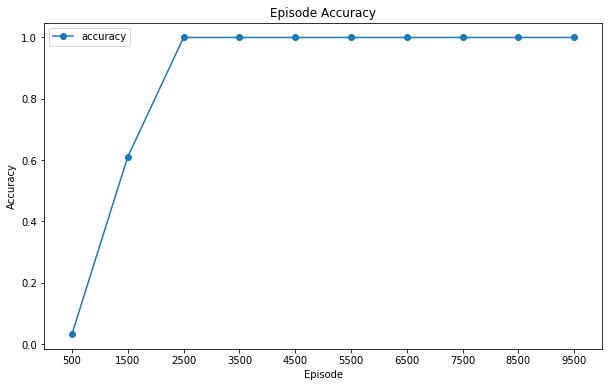

In [7]:
show(a, mean_size=1000)

In [8]:
a = evaluation(model, 50, 1000, 100)

[  100] error : 0.0	284180217812168 + 427418231364109 = 711598449176277, model:711598449176277
[  200] error : 0.0	106086698351916 + 381099900944865 = 487186599296781, model:487186599296781
[  300] error : 0.0	493609432284964 + 429408245583437 = 923017677868401, model:923017677868401
[  400] error : 0.0	201388324105683 + 193727802732695 = 395116126838378, model:395116126838378
[  500] error : 0.0	555837788854974 + 105086370267621 = 660924159122595, model:660924159122595
[  600] error : 0.0	541954122925236 + 131979578890126 = 673933701815362, model:673933701815362
[  700] error : 0.0	314048864387329 + 483572529896816 = 797621394284145, model:797621394284145
[  800] error : 0.0	111507964639023 + 367567337132449 = 479075301771472, model:479075301771472
[  900] error : 0.0	138062906325698 + 518298847721268 = 656361754046966, model:656361754046966
[ 1000] error : 0.0	384076531568720 + 369948375531635 = 754024907100355, model:754024907100355
Accuracy : 1.000%


# Discussion

In [ ]:
all_accs = []
for td in [2, 4, 6, 8]:
    accs = []
    __model = RNN(2, 2, 16)
    train(__model, td, 10000, show_size=20000)
    for ed in range(10, 51, 5):
        acc, _, _ = evaluation(__model, ed, 1000, show_size=1001)
        accs.append(acc)
    print('Done ', td)
    all_accs.append(accs)

In [ ]:
plt.figure(figsize=(7, 4))
plt.title('Extend number of binary bit')
for i, td in enumerate([2, 4, 6, 8]):
    x = list(range(10, 51, 5))
    y = all_accs[i]
    plt.plot(x, y, label='train digits = '+str(td))
plt.legend()
plt.xlabel('evaluation digits')
plt.ylabel('accuracy')

In [ ]:
all_accs = []
for hu in range(1,16):
    accs = []
    __model = RNN(2, 2, hu)
    train(__model, 8, 10000, show_size=20000)
    for ed in range(8, 49, 8):
        acc, _, _ = evaluation(__model, ed, 1000, show_size=1001)
        accs.append(acc)
    print('Done ', hu)
    all_accs.append(accs)

In [ ]:
plt.figure(figsize=(7, 4))
plt.title('Diff hidden unit in model')
x = list(range(1,16))
y = []
for i, td in enumerate(x):
    y.append(sum(all_accs[i]) / len(all_accs[i])) 

plt.plot(x, y)
#plt.legend()
plt.xlabel('number of hidden unit')
plt.ylabel('average of accuracy')

In [ ]:
class pytorchRNN():
    def __init__(self, model):
        self.U = torch.tensor(model.U.data, requires_grad=True)
        self.W = torch.tensor(model.W.data, requires_grad=True)
        self.V = torch.tensor(model.V.data, requires_grad=True)
        self.b = torch.tensor(model.b.data, requires_grad=True)
        self.c = torch.tensor(model.c.data, requires_grad=True)
    
    def forward(self, x):
        t = len(x)
        self.h = None
        y = []
        
        for i in range(t):
            a = self.b + (torch.tensor(x[i].data, requires_grad=True) @ self.U)
            if self.h is not None:
                a += (self.h @ self.W)
            self.h = a.tanh()
            
            o = self.c + (self.h @ self.V)
            y.append(o)
            
        return y
    
    def zero_grad(self):
        if self.U.grad is None:
            return;
        with torch.no_grad():
            self.U.grad.zero_()
            if self.W.grad is not None:
                self.W.grad.zero_()
            self.V.grad.zero_()
            self.b.grad.zero_()
            self.c.grad.zero_()
    
    def step(self, lr=1e-1):
        if self.U.grad is None:
            return;
        with torch.no_grad():
            self.U -= lr * self.U.grad
            if self.W.grad is not None:
                self.W -= lr * self.W.grad
            self.V -= lr * self.V.grad
            self.b -= lr * self.b.grad
            self.c -= lr * self.c.grad

In [ ]:
import torch

def testGrad():
    n = 1
    c = 5
    x = np.random.random((n,2))
    h = np.random.random((n,16))
    y = np.random.randint(0, c, n)
    
    u = np.random.random((2, 16))
    w = np.random.random((16,16))
    v = np.random.random((16, c))
    
    def equation(*args):
        x, h, u, w, v = args
        h1 = ((x @ u) + (h @ w)).tanh()
        return ((x @ u) + (h1 @ w)).tanh() @ v
    
    def allv(l):
        return [Variable(i) for i in l]

    def allt(l):
        return [torch.tensor(i, requires_grad=True) for i in l]
    
    wow = [x, h, u, w, v]
    
    Vs = allv(wow)
    Ts = allt(wow)
    Y = Variable(y)
    _Y = torch.tensor(y.astype(np.float), requires_grad=True)
    
    A = equation(*Vs)
    A = A.crossentropy(Y)
    _A = equation(*Ts)
    _A = torch.nn.CrossEntropyLoss(reduction='sum')(_A, _Y.long())
    #_A = torch.nn.MSELoss()(_A, _A)
    
    print(A, _A)
    
    A.backward(np.array(1))
    _A.backward()
    
    t = None
    
    for V, T in zip(Vs, Ts):
        r = torch.allclose(torch.tensor(V.grad), T.grad)
        print(torch.allclose(torch.tensor(V.grad), T.grad))
        if t is None:
            t = r
        else:
            t &= r
    
    return t
testGrad()

In [ ]:
model = RNN(2, 2, 16)
model2 = pytorchRNN(model)

In [ ]:
epoch_size = 20000
error = 0
error2 = 0

all_error = []
all_loss = []

dataset = BinaryDataset(8)

for epoch in range(epoch_size):
    x, y = next(dataset)
    
    model.zero_grad()
    model2.zero_grad()
    
    output = model.forward(x)
    output2 = model2.forward(x)
    
    loss = [output[i].crossentropy(y[i]) for i in range(len(y))]
    loss2 = [torch.nn.CrossEntropyLoss(reduction='sum')(output2[i], torch.tensor(y[i].data[0,]).long()) for i in range(len(y))]
    for l in loss[::-1]:
        l.backward(np.array(1))
    for l in loss2[::-1]:
        l.backward(retain_graph=True)
        
    model.step(1e-2)
    model2.step(1e-2)
    
    e = np.count_nonzero([np.all(output[i].argsoftmax().data != y[i].data) for i in range(len(y))])
    error += e
    all_error.append(e)
    all_loss.append(sum([l.data for l in loss]))
    
    error2 += sum([(torch.max(output2[i], 1)[1] != torch.tensor(y[i].data[0,]).long()).sum().item() for i in range(len(y))])
    if (epoch+1) % 1000 == 0:
        print('[{:5d}] error : {} - {}, loss : {} - {}'.format(epoch+1, error / 1000, error2 / 1000, sum([l.data for l in loss]), float(sum(loss2))))
        error = 0
        error2 = 0

In [ ]:
mean_size=100

tmp = all_error[:10000]

x = [i*mean_size for i in range(len(tmp)//mean_size)]
y = [sum(all_error[i*mean_size:(i+1)*mean_size])/ mean_size for i in range(len(tmp)//mean_size)]
y2 = [sum(all_loss[i*mean_size:(i+1)*mean_size])/ mean_size for i in range(len(all_loss[:10000])//mean_size)]

plt.figure(figsize=(10,6))
plt.title('Episode Error')
plt.xlabel('Episode')
plt.ylabel('Error')
plt.plot(x, y, '-o', label='error')
plt.plot(x, y2, '-o', label='loss')

In [ ]:
eval_size = 1000
error = 0
error2 = 0

accuracy = 0

eval_dataset = BinaryDataset(50)

for i in range(eval_size):
    x, y = next(eval_dataset)
    
    output, _ = model.forward(x)
    output2, _ = model2.forward(x)
    
    e = np.count_nonzero([np.all(output[i].argsoftmax().data != y[i].data) for i in range(len(y))])
    error += e
    error2 += sum([(torch.max(output2[i], 1)[1] != torch.tensor(y[i].data[0,]).long()).sum().item() for i in range(len(y))])
    
    
    if e == 0:
        accuracy += 1
    
    output = [float(o.argsoftmax().data) for o in output]
    output2 = [float(torch.max(o, 1)[1]) for o in output2]
    
    x = np.concatenate([v.data for v in x]).T
    y = np.concatenate([v.data for v in y]).T
    
    #print('[{:4d}] {:d} + {:d} = {:d}, m1:{}, m2:{}'.format(i, toNumber(x[0,:]), toNumber(x[1, :]), toNumber(y[0,:]), toNumber(output), toNumber(output2)))
print('m1 error : {}, m2 error : {}'.format(error/eval_size, error2/eval_size))
print('Accuracy : {:.3f}%'.format(accuracy / eval_size))